In [10]:
import json
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt

from src.Wordle import Wordle

In [118]:
with open(r'..\data\processed\wordle_words.json') as infile:
    word_list = json.load(infile)
word_list = [word.upper() for word in word_list]

In [56]:
chardf = pd.DataFrame([list(word.upper()) for word in word_list]).dropna(axis=1)
chardf

,0,1,2,3,4
0,C,I,G,A,R
1,R,E,B,U,T
2,S,I,S,S,Y
3,H,U,M,P,H
4,A,W,A,K,E
...,...,...,...,...,...
12967,Z,U,Z,I,M
12968,Z,Y,G,A,L
12969,Z,Y,G,O,N
12970,Z,Y,M,E,S


In [181]:
class Wordle:
    def __init__(self, word=None, n_guesses=6, n_letters=5, all_words=word_list, ben_mode=False):
        self.ben_mode = ben_mode
        if word == None:
            self.word = random.sample(set(all_words), 1)[0]
        else:
            self.word = word.upper()
        self.n_guesses = n_guesses
        self.n_letters = n_letters
        self.guess_counter = n_guesses
        self.greens = [None] * self.n_letters 
        self.current_yellows = [None] * self.n_letters
        self.yellows_pos = {i: [] for i in range(self.n_letters)}
        self.guessed_words = []
        self.all_words = [word.upper() for word in all_words]
        self.absent_letters = []
        self.present_letters = []
        self.correct_positions = [None] * self.n_letters # greens would be differnt per guess, remember correct positions
        self.state = None
        self.qstate = [0] * self.n_letters
        self.tmp_qstate = [0] * self.n_letters
        self.win = False
        self.yellowlist = []
        
    def try_word(self, guess):
        # need to add a check for not doing anything if the word is already guessed correctly
        guess = guess.upper()
        self.state = None
        self.current_yellows = [None] * self.n_letters 
        self.current_greens = [None] * self.n_letters
        self.tmp_qstate = [0] * self.n_letters
        
        if not self.ben_mode: print('guessed: ', guess)
        if not len(guess) == self.n_letters:
            raise ValueError('wrong word length')
        if guess not in self.all_words:
            raise ValueError('invalid word')
        if guess in self.guessed_words:
            raise ValueError('word already guessed')
        self.guessed_words.append(guess)
        # c_g = character_guess,  c_w = character_word
        for i, (c_g, c_w) in enumerate(zip(guess, self.word)):
            if c_g == c_w:
                self.greens[i] = c_g
                self.correct_positions[i] = c_g
                self.qstate[i] = 1
                self.tmp_qstate[i] = 1
            # Check for number of non-None in greens list 
            if sum(bool(char) for char in self.greens) == self.n_letters:
                self.state = True
                self.win = True
                print('victory! word is: ' + self.word) 
                grn_sum = sum([x!=None for x in self.greens])
                yel_sum = sum([x!=None for x in self.current_yellows])
                
                if self.ben_mode:
                    return self.ben_mode_return()
                else:
                    return grn_sum, yel_sum
            if c_g in self.word and c_g != c_w:
                self.yellows_pos[i].append(c_g)
                self.current_yellows[i] = c_g
                if c_g not in self.yellowlist:
                    self.yellowlist += c_g
            if c_g in self.word: # track the letters that are there for the AI later
                self.present_letters.append(c_g)
            if c_g not in self.word: # track letters that are not there for the AI
                self.absent_letters.append(c_g)
        self.guess_counter -= 1
        grn_sum = sum([x!=None for x in self.greens])
        yel_sum = sum([x!=None for x in self.current_yellows])
        
        if self.guess_counter == 0:
            self.state=True
            self.win = False
            if not self.ben_mode: print("YOU LOSE-TOO MANY GUESSES")
            if self.ben_mode:
                return self.ben_mode_return()
            else:
                return grn_sum, yel_sum # return number of greens and number of yellows
        if not self.ben_mode: 
            print('Greens:' + str(self.greens) + 
                  '\nYellows: ' + str(self.yellows_pos) + 
                  '\nGuesses left: ' + str(self.guess_counter))
        
        if self.ben_mode:
            return self.ben_mode_return()
        else:
            return grn_sum, yel_sum # return number of greens and number of yellows
    
    def ben_mode_return(self):
        return self.greens, self.yellowlist, self.absent_letters

In [132]:
w = Wordle('chafe', ben_mode=True)

In [133]:
w.try_word('flame')

([None, None, 'A', None, 'E'], ['F'], ['L', 'M'])

In [37]:
# w.try_word('hello')

(False,
 [None, None, 'A', None, 'E'],
 ['H', 'E', 'F'],
 {0: ['H', 'F'], 1: ['E'], 2: [], 3: [], 4: []})

In [136]:
def word_filter(output, word_list=word_list):
    """
    Takes in output from Wordle class and filters the list of words for possible corrects.
    Uses chardf (pandas DF separated one char per column) for easy filtering
    Returns list of words that could work. 
    """
    
    greens, yellows, absent_letters = output
    
    absent_filter = []
    for word in word_list:
        if not any(letter in word for letter in absent_letters):
            absent_filter.append(word)
    
    yellow_filter = []
    for word in absent_filter:
        if all(letter in word for letter in yellows):  # checks for presence of yellows in all words
            yellow_filter.append(word)
            
    final = []
    for word in yellow_filter: 
        if all(letter == word[i] for i, letter in enumerate(greens) if letter is not None):
            final.append(word)
        
    return final

In [137]:
test = ([None, None, 'A', None, 'E'], ['F'], ['L', 'M'])

In [186]:
word_filter(test)

['CHAFE', 'FEARE', 'FEASE', 'FEAZE', 'FRAPE', 'FRATE', 'NEAFE']

In [187]:
result = []

for word in word_list:
    w = Wordle(word, ben_mode=True)
    w.try_word('SAINT')
    w.try_word('CORED')
    w.try_word('BULKY')
    f = word_filter(w.try_word('WHOMP'))
    result.append((len(f), f))

victory! word is: CORNY
victory! word is: CORNY
victory! word is: SAINT
victory! word is: SAINT
victory! word is: SAINT
victory! word is: SAINT
victory! word is: SHIED
victory! word is: BURNT
victory! word is: BURNT
victory! word is: SULKY
victory! word is: SULKY
victory! word is: WHINY
victory! word is: SHINY
victory! word is: BALMY
victory! word is: BULKY
victory! word is: BULKY
victory! word is: BALED
victory! word is: BALED
victory! word is: BALKY
victory! word is: BALKY
victory! word is: BARED
victory! word is: BARED
victory! word is: BARKY
victory! word is: BARKY
victory! word is: BARMY
victory! word is: BARNY
victory! word is: BARNY
victory! word is: BOOED
victory! word is: BOOKY
victory! word is: BOOMY
victory! word is: BORED
victory! word is: BORED
victory! word is: BURET
victory! word is: BURET
victory! word is: CALMY
victory! word is: CARED
victory! word is: CARED
victory! word is: CARED
victory! word is: CARET
victory! word is: CARET
victory! word is: CARET
victory! word is

In [188]:
rdf = pd.DataFrame(result)
rdf.columns = ['num_poss', 'poss_words']
rdf['w'] = word_list
rdf = rdf.set_index('w')
rdf.sort_values('num_poss', ascending=False).head(50)

,num_poss,poss_words
w,,
ALEFS,32,"[SLAVE, FALSE, EASEL, LEASE, SALVE, ALEFS, AVE..."
LEASE,32,"[SLAVE, FALSE, EASEL, LEASE, SALVE, ALEFS, AVE..."
AXELS,32,"[SLAVE, FALSE, EASEL, LEASE, SALVE, ALEFS, AVE..."
ZEALS,32,"[SLAVE, FALSE, EASEL, LEASE, SALVE, ALEFS, AVE..."
ERASE,32,"[SAFER, ERASE, AGERS, AREAS, ARSES, AVERS, EAS..."
AVELS,32,"[SLAVE, FALSE, EASEL, LEASE, SALVE, ALEFS, AVE..."
FEARS,32,"[SAFER, ERASE, AGERS, AREAS, ARSES, AVERS, EAS..."
GEARS,32,"[SAFER, ERASE, AGERS, AREAS, ARSES, AVERS, EAS..."
FEALS,32,"[SLAVE, FALSE, EASEL, LEASE, SALVE, ALEFS, AVE..."


In [199]:
print('Total number of possible words: ', rdf['num_poss'].sum())
print('Average number of possibilities per word: ', round(rdf['num_poss'].sum() / len(word_list), 2))

Total number of possible words:  35966
Average number of possibilities per word:  2.77


In [213]:
len(word_list)

12972

Text(0.5, 1.0, 'Number of possible remaining correct words after SAINT CORED BULKY WHOMP\nusing all 12972 words')

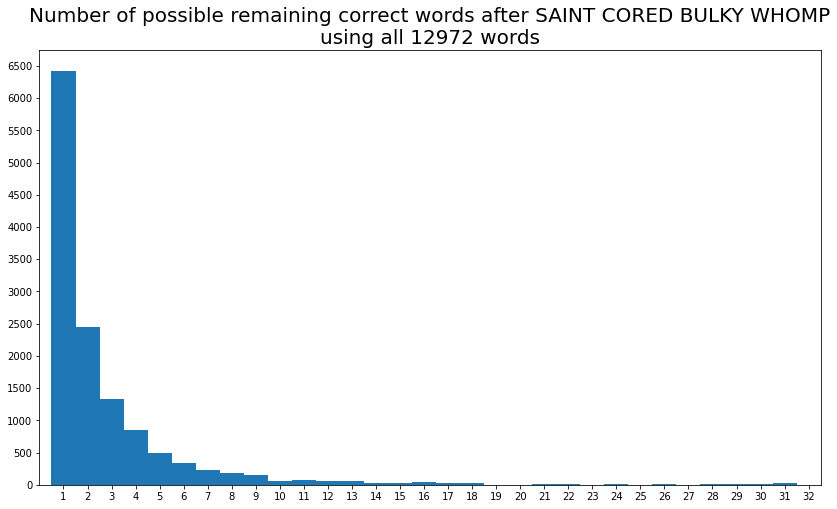

In [220]:
# plt.xlim((0, 50))
rdf['num_poss'].hist(bins=31)
plt.gcf().set_size_inches((14, 8))
ax = plt.gca()
ax.grid(alpha=0)
plt.xlim((0.5, 33))
plt.xticks(ticks=[x + 0.5 for x in range(1, 33, 1)], labels=[x for x in range(1, 33, 1)])
plt.yticks(ticks=[x for x in range(0, 7000, 500)])
plt.title('Number of possible remaining correct words after SAINT CORED BULKY WHOMP\nusing all 12972 words', fontsize=20)
# plt.ylabel('count')

## To compare the 4-word SAINT CORED BULKY WHOMP to a random baseline, perform random sampling of words 

In [182]:
w = Wordle('RARES')
w.try_word('SAINT')

guessed:  SAINT
Greens:[None, 'A', None, None, None]
Yellows: {0: ['S'], 1: [], 2: [], 3: [], 4: []}
Guesses left: 5


(1, 1)

In [183]:
w.try_word('CORED')

guessed:  CORED
Greens:[None, 'A', 'R', 'E', None]
Yellows: {0: ['S'], 1: [], 2: [], 3: [], 4: []}
Guesses left: 4


(3, 0)

In [184]:
w.try_word('BULKY')

guessed:  BULKY
Greens:[None, 'A', 'R', 'E', None]
Yellows: {0: ['S'], 1: [], 2: [], 3: [], 4: []}
Guesses left: 3


(3, 0)

In [185]:
w.try_word('whomp')

guessed:  WHOMP
Greens:[None, 'A', 'R', 'E', None]
Yellows: {0: ['S'], 1: [], 2: [], 3: [], 4: []}
Guesses left: 2


(3, 0)